This file contains the work process we performed in order to create the data to be used with NetoworkX & Gephi

In [6]:
import pandas as pd

Creating the base DF:

In [7]:
file_path = 'wikipedia_articles.csv'
articles_df = pd.read_csv(file_path, index_col=0, encoding='utf-8')

Create the Nodes dataset from the clean DF:

Create the Edges dataset from the clean DF:

In [8]:
# First, we will create the nodes table
ser_values = articles_df.iloc[:, 0]
ser_pointers_old = articles_df.iloc[:, 3]
# Cleaning ser_pointers because it contains strings with the nodes we want
temp_lst = []
for row in ser_pointers_old:
    if type(row) != float:
        temp_split = row.split(", ")
        for i in temp_split:
            temp_lst.append(i)
ser_pointers = pd.Series(temp_lst)
# Merging the two sets for one nodes set
ser_combined = ser_values.append(ser_pointers)
ser_combined = ser_combined.unique()

nodes_df = pd.DataFrame(ser_combined)

edges_dict = {"Source": [], "Target": []}
for i in range(len(ser_pointers_old)):
    if type(ser_pointers_old[i]) != float:
        temp_split = ser_pointers_old[i].split(", ")
        for j in temp_split:
            edges_dict["Source"].append(ser_values[i])
            edges_dict["Target"].append(j)
edges_df = pd.DataFrame(edges_dict)
edges_df


Source                  Target
0       Ukrainia  Architecture of Poland
1       Ukrainia             Great Purge
2       Ukrainia         Mykola Khvylovy
3       Ukrainia               Romanians
4       Ukrainia             Belarusians
...          ...                     ...
197410     Wolin                Volhynia
197411     Wolin                  Poland
197412     Wolin          Mead in Poland
197413     Wolin                  Forest
197414     Wolin         German language

[197415 rows x 2 columns]

Creating the base DF to use in the creation of the nodes & edges:

In [10]:
DATES_FOR_CHECKING = [
  ('20180401', '20180501'),
  ('20180501', '20180601'),
  ('20190901', '20191001'),
  ('20191001', '20191101'),
  ('20220101', '20220201'),
  ('20220201', '20220301')
]
DATES_STRINGS = [f'{pair[0]}-{pair[1]}' for pair in DATES_FOR_CHECKING]

articles_df[DATES_STRINGS] = articles_df[DATES_STRINGS].astype(int) # Change types of columns from float to int
articles_df['id'] = articles_df.index # Create an ID column for Gephi's usage
articles_df['total_relevance'] = articles_df['ukraine_relevance'] + articles_df['russia_relevance']
articles_df.rename(columns={'value': 'Label'}, inplace=True) # Replace column name for Gephi's format
pointers_set = set(articles_df['Label']) # Unique set of pointers for future usage.
articles_df['pointers'] = articles_df['pointers'].astype(str)

def convert_pointers_to_ids(pointers_string):
  # This function converts pointers from a list of string to a list of pointers,
  # in order to minimize the size of the files.
  pointers_list = pointers_string.split(', ') # Create a list of strings from the pointers
  pointers_in_df_set = set(pointers_list) & set(pointers_set) # Leave only the pointers which exist under the Labels column.
  pointers_ids = [articles_df.loc[articles_df['Label'] == pointer, 'id'].iloc[0] for pointer in pointers_in_df_set] # Convert to a list of ids.
  return pointers_ids

articles_df['pointers_ids'] = articles_df['pointers'].apply(convert_pointers_to_ids)
articles_df.sort_values('id', inplace=True)
articles_df.head()

Label  ukraine_relevance  russia_relevance  \
0                    Ukrainia                437               135   
1                     Ukraine                436               135   
2              War in Donbass                368               306   
3  RussiaâUkraine relations                349               332   
4          Ukrainian language                346               129   

                                            pointers  20180401-20180501  \
0  Architecture of Poland, Great Purge, Mykola Kh...                218   
1  Architecture of Poland, Great Purge, Mykola Kh...             228629   
2  Soledar, Kyiv Post, Post-Soviet conflicts, Tri...              72012   
3  Lazar Kaganovich, Belarusians, Rivne Nuclear P...               7618   
4  Russian Empire Census, Great Purge, Turkic peo...              35159   

   20180501-20180601  20190901-20191001  20191001-20191101  20220101-20220201  \
0                173                185                161                394   
1             259346             320373             305501            1342625   
2              79062              77510              78256             232111   
3               7754              12557              10797             131310   
4              40111              35751              38397              77086   

   20220201-20220301  id  total_relevance  \
0               1331   0              572   
1           10093079   1              571   
2            1185121   2              674   
3            1836700   3              681   
4             431072   4              475   

                                        pointers_ids  
0  [403, 829, 586, 149, 605, 59, 3063, 62, 145, 1...  
1  [403, 829, 586, 149, 6705, 605, 59, 3063, 62, ...  
2  [431, 5126, 89, 1141, 6705, 1581, 1264, 1166, ...  
3  [34, 1027, 3750, 1206, 229, 149, 90, 66, 307, ...  
4  [3286, 3184, 739, 3539, 89, 1419, 1205, 149, 2...

Create the Nodes & Edges datasets for every pageviews dates range:

In [11]:
def create_edges_df_from_nodes_df(nodes_df):
    edges_dict = {"Source": [], "Target": []} # Dict which will be used to generate the DF

    values = nodes_df['id'].to_list() # Get a list of all the values
    values_set = set(values) # Create a set of unique values in this DF
    # Create a list of lists, which will contain all of the pointers:
    pointers = nodes_df['pointers_ids'] #.apply(lambda x: x.split(", ")).to_list()
    for i in range(len(values)): # Run through all indexes of values
        pointers_in_df_set = set(values_set) & set(pointers.iloc[i]) # Make sure there aren't any pointers which don't have matching values in this DF
        for item in pointers_in_df_set: # and on each item on every pointers sublist
            # if item in values:   # if the item on the pointers sublist is on the values list
            edges_dict["Source"].append(values[i]) # Add the value as the source
            edges_dict["Target"].append(item)      # and the item as the target

    edges_df = pd.DataFrame(edges_dict) # Create a dict with two columns - 'Source' & 'Target'
    return edges_df

def create_nodes_df_for_date_range(df, date_string):
     # Get the relevant columns from the base DF where the pageviews aren't zero:
    nodes_df = df[['id', 'Label', 'total_relevance', date_string, 'pointers_ids']][df[date_string] != 0].rename(columns={date_string: 'pageviews'})
    return nodes_df

# Create two dictionaries with the dates range as the keys and the corresponding DFs as the values:
nodes = {dates_string: create_nodes_df_for_date_range(articles_df, dates_string) for dates_string in DATES_STRINGS}
edges = {dates_string: create_edges_df_from_nodes_df(nodes[dates_string]) for dates_string in DATES_STRINGS}

## Analysis of the network
Using networksx

### Imports

In [13]:
import networkx as nx
import matplotlib.pylab as plt
import powerlaw

### Defining G graph

In [14]:
G = nx.from_pandas_edgelist(edges_df,"Source","Target",create_using=nx.DiGraph)
# Importing the graphs of the events, for research question no. 2
G_events={"A":[],"B":[],"C":[]}

before2018_edges_df = edges[DATES_STRINGS[0]].copy()
G_events["A"].append(nx.from_pandas_edgelist(before2018_edges_df,"Source","Target",create_using=nx.DiGraph))

after2018_edges_df = edges[DATES_STRINGS[1]].copy()
G_events["A"].append(nx.from_pandas_edgelist(after2018_edges_df,"Source","Target",create_using=nx.DiGraph))

before2019_edges_df = edges[DATES_STRINGS[2]].copy()
G_events["B"].append(nx.from_pandas_edgelist(before2019_edges_df,"Source","Target",create_using=nx.DiGraph))

after2019_edges_df = edges[DATES_STRINGS[3]].copy()
G_events["B"].append(nx.from_pandas_edgelist(after2019_edges_df,"Source","Target",create_using=nx.DiGraph))

before2022_edges_df = edges[DATES_STRINGS[4]].copy()
G_events["C"].append(nx.from_pandas_edgelist(before2022_edges_df,"Source","Target",create_using=nx.DiGraph))

after2022_edges_df = edges[DATES_STRINGS[5]].copy()
G_events["C"].append(nx.from_pandas_edgelist(after2022_edges_df,"Source","Target",create_using=nx.DiGraph))

### Information about the graph

In [15]:
def info(G):
    print(nx.info(G))
print("Basic network:")
info(G)
print("\nBefore special events networks:")
for i in G_events:
    info(G_events[i][0])
print("\nAfter special events networks:")
for i in G_events:
    info(G_events[i][1])

Basic network:
DiGraph with 7583 nodes and 197415 edges

Before special events networks:
DiGraph with 7313 nodes and 190040 edges
DiGraph with 7419 nodes and 192722 edges
DiGraph with 7549 nodes and 195616 edges

After special events networks:
DiGraph with 7316 nodes and 190096 edges
DiGraph with 7425 nodes and 192802 edges
DiGraph with 7561 nodes and 196285 edges


### Diameter

In [16]:
def calc_diameter(G):
    return max([max(j.values()) for (i,j) in nx.shortest_path_length(G)])
print("Basic network diameter: " +str(calc_diameter(G)))
for i in G_events:
    str_to_print= "\nBefore event " + i +" network diameter: "
    print(str_to_print + str(calc_diameter(G_events[i][0])))
    str_to_print = "After event " + i + " network diameter: "
    print(str_to_print + str(calc_diameter(G_events[i][1])))

Basic network diameter: 9

Before event A network diameter: 9
After event A network diameter: 9

Before event B network diameter: 9
After event B network diameter: 9

Before event C network diameter: 9
After event C network diameter: 9


### Average Shortest Path Length
We weren't able to calculate this value after consulting with the course staff, running it will cause an error:

In [55]:
# average_shortest_path_length = nx.average_shortest_path_length(G)

### Degree Histogram
In log-log scale

In [19]:
def degree_hist_in(G,name=None):
    in_degrees = G.in_degree()
    in_degrees=dict(in_degrees)
    in_values = sorted(set(in_degrees.values()))
    in_hist = [list(in_degrees.values()).count(x) for x in in_values]

    plt.figure() 
    plt.grid(False)
    plt.loglog(in_values, in_hist, 'r.') 
    plt.xlabel('log k')
    plt.ylabel('p(k)')

In [20]:
def degree_hist_out(G,name=None):
    out_degrees = G.out_degree()
    out_degrees=dict(out_degrees)
    out_values = sorted(set(out_degrees.values()))
    out_hist = [list(out_degrees.values()).count(x) for x in out_values]

    plt.figure() 
    plt.grid(False)
    plt.loglog(out_values, out_hist, 'r.') 
    plt.xlabel('log k')
    plt.ylabel('p(k)')

The basic network:

Text(0.5, 1.0, 'Basic Network In Degree Distribution')

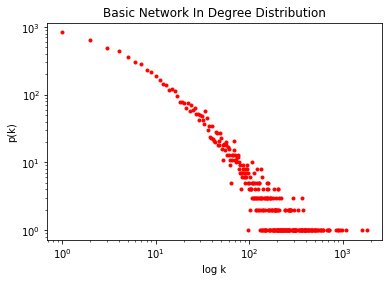

In [21]:
degree_hist_in(G)
plt.title("Basic Network In Degree Distribution")

Text(0.5, 1.0, 'Basic Network Out Degree Distribution')

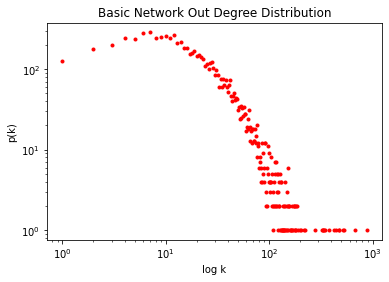

In [22]:
degree_hist_out(G)
plt.title("Basic Network Out Degree Distribution")

The special events networks:

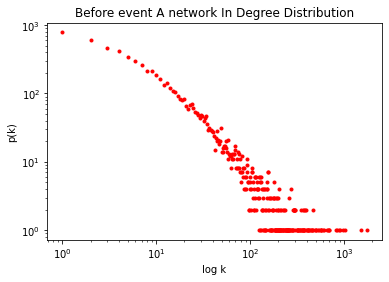

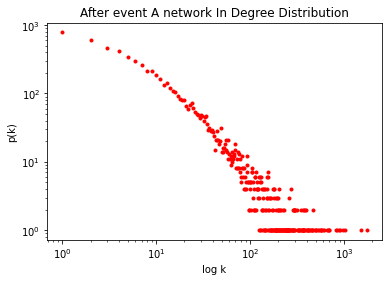

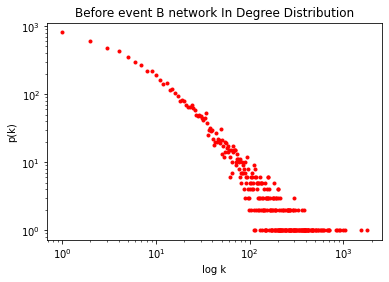

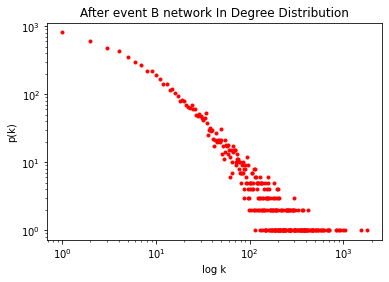

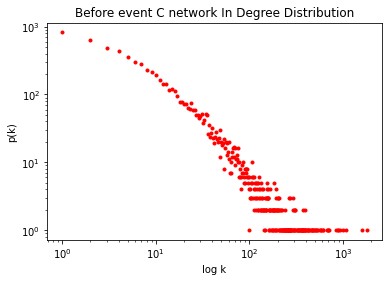

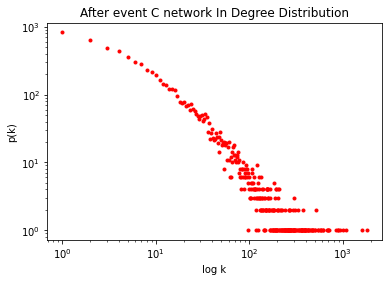

In [23]:
for i in G_events:
    name = "Before event " + i + " network"
    degree_hist_in(G_events[i][0],name)
    plt.title(name +" In Degree Distribution")
    name = "After event " + i + " network"
    degree_hist_in(G_events[i][1],name)
    plt.title(name +" In Degree Distribution")

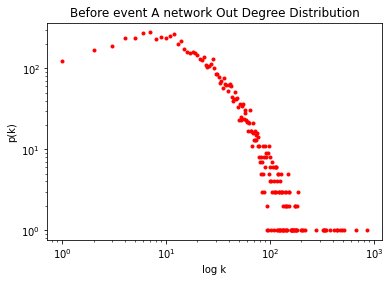

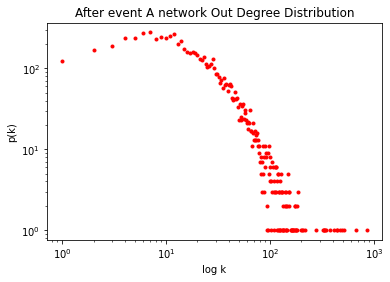

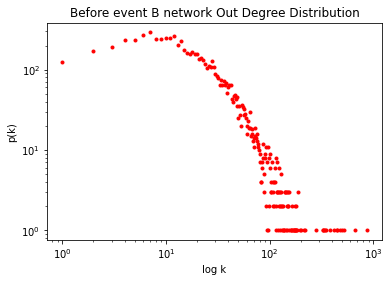

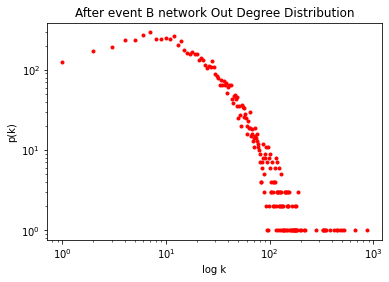

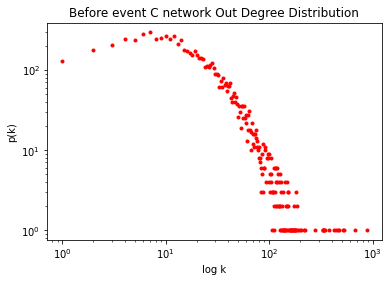

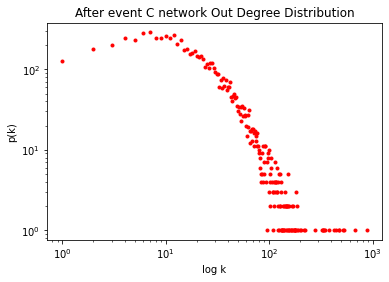

In [24]:
for i in G_events:
    name = "Before event " + i + " network"
    degree_hist_out(G_events[i][0],name)
    plt.title(name +" Out Degree Distribution")
    name = "After event " + i + " network"
    degree_hist_out(G_events[i][1],name)
    plt.title(name +" Out Degree Distribution")

As we can see, in the both of the plots, there is somewhat of a linear trend.

In [25]:
def degree_seq_in(G,name=None):
    degree_sequence = sorted([d for n,d in G.in_degree()],reverse=True)
    plt.xlabel("k")
    plt.ylabel("Number of nodes with k links ")
    plt.plot(degree_sequence, label=name)
    return degree_sequence

In [26]:
def degree_seq_out(G,name=None):
    degree_sequence = sorted([d for n,d in G.out_degree()],reverse=True)
    plt.xlabel("k")
    plt.ylabel("Number of nodes with k links ")
    plt.plot(degree_sequence,label=name)
    return degree_sequence

### Degree Ploting

Basic network - in:

Text(0.5, 1.0, 'Basic network - In')

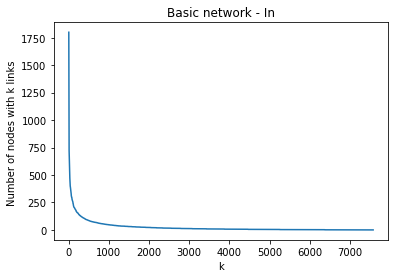

In [27]:
DS_G_in=degree_seq_in(G)
plt.title("Basic network - In")

Out:

Text(0.5, 1.0, 'Basic network - Out')

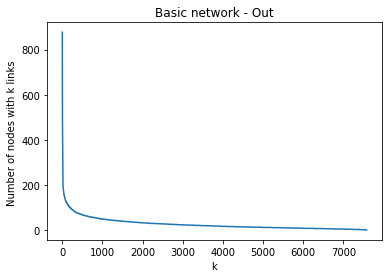

In [28]:
DS_G_out=degree_seq_out(G)
plt.title("Basic network - Out")

Special events networks - in:

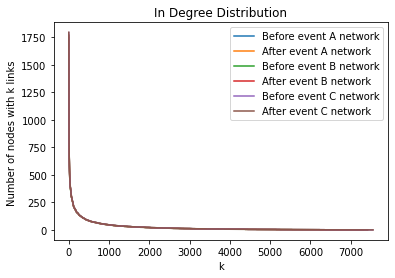

In [29]:
DS_G_events_in = {"A":[],"B":[],"C":[]}
for i in G_events:
    name = "Before event " + i + " network"
    DS_G_events_in[i].append(degree_seq_in(G_events[i][0],name))
    plt.legend()
    name = "After event " + i + " network"
    DS_G_events_in[i].append(degree_seq_in(G_events[i][1],name))
    plt.legend()
    plt.title("In Degree Distribution")

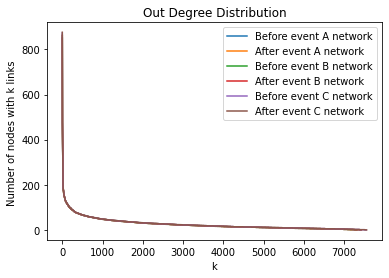

In [30]:
DS_G_events_out = {"A":[],"B":[],"C":[]}
for i in G_events:
    name = "Before event " + i + " network"
    DS_G_events_out[i].append(degree_seq_out(G_events[i][0],name))
    plt.legend()
    name = "After event " + i + " network"
    DS_G_events_out[i].append(degree_seq_out(G_events[i][1],name))
    plt.legend()
    plt.title("Out Degree Distribution")

As we can see, the wikipedia networks is has a power law degree distribution, that indicates that this network is a Scale Free network.

### Fitting power law disribution to our networks

In [31]:
def power_law_fit(degree_sequence):
    fit = powerlaw.Fit(degree_sequence,discrete=True)
    gamma = fit.power_law.alpha
    print("gamma=",gamma)

Basic network:

In [32]:
power_law_fit(DS_G_in)
power_law_fit(DS_G_out)

Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit
gamma= 3.5540575561183405
Calculating best minimal value for power law fit
gamma= 3.446907590666666


Values less than or equal to 0 in data. Throwing out 0 or negative values


The special events networks - in:

In [33]:
for i in DS_G_events_in:
    str_to_print = "Before event " + i + " network:"
    print(str_to_print)
    power_law_fit(DS_G_events_in[i][0])
    str_to_print = "After event " + i + " network:"
    print(str_to_print)
    power_law_fit(DS_G_events_in[i][1])
    print()

Before event A network:
Calculating best minimal value for power law fit


Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values


gamma= 2.3753347255033725
After event A network:
Calculating best minimal value for power law fit
gamma= 2.3764298661415033

Before event B network:


Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit


Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values


gamma= 2.3925220513095278
After event B network:
Calculating best minimal value for power law fit
gamma= 3.5368077628280314

Before event C network:
Calculating best minimal value for power law fit
gamma= 2.381435224190949
After event C network:
Calculating best minimal value for power law fit
gamma= 3.482718789957848



In [34]:
for i in DS_G_events_out:
    str_to_print = "Before event " + i + " network:"
    print(str_to_print)
    power_law_fit(DS_G_events_out[i][0])
    str_to_print = "After event " + i + " network:"
    print(str_to_print)
    power_law_fit(DS_G_events_out[i][1])
    print()

Before event A network:
Calculating best minimal value for power law fit
gamma= 3.5134937263280026
After event A network:
Calculating best minimal value for power law fit
gamma= 3.5131011501746823

Before event B network:
Calculating best minimal value for power law fit
xmin progress: 80%

Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values


gamma= 3.478039085125584
After event B network:
Calculating best minimal value for power law fit
gamma= 3.4778712164392824

Before event C network:
Calculating best minimal value for power law fit
gamma= 3.4628631027450285
After event C network:
Calculating best minimal value for power law fit
gamma= 3.462037812810196



### Average Degree

Basic network:

In [35]:
2*G.number_of_edges() / float(G.number_of_nodes())

52.067783199261505

Special events networks:

In [36]:
for i in G_events:
    str_to_print = "Before event " + i + " network:"
    print(str_to_print)
    print(2*G_events[i][0].number_of_edges() / float(G_events[i][0].number_of_nodes()))
    str_to_print = "After event " + i + " network:"
    print(str_to_print)
    print(2*G_events[i][1].number_of_edges() / float(G_events[i][1].number_of_nodes()))
    print()

Before event A network:
51.97319841378367
After event A network:
51.96719518862766

Before event B network:
51.95363256503572
After event B network:
51.93319865319865

Before event C network:
51.82567227447344
After event C network:
51.92038090199709



In [37]:
nx.is_weakly_connected(G)

False

## Networks Centrality Measures
In this section, we want to answer our research quenstion by measuring the different centrality measures and understanding the meaning of the results.

### The functions to calculate the measures:

#### Getting Top 5 Maximum Values

In [39]:
def top_five(A):
    return sorted(A, key=A.get, reverse=True)[:5]

#### Degree Centrality

In [40]:
def degree_centrality(G):
    return top_five(nx.degree_centrality(G))

#### In Betweenness

In [41]:
def betweenness(G):
    return top_five(nx.betweenness_centrality(G))

#### In-Degree Centrality

In [42]:
def in_degree (G):
    return top_five(nx.in_degree_centrality(G))

#### Out-Degree Centrality

In [43]:
def out_degree(G):
    return top_five(nx.out_degree_centrality(G))

#### Closeness

In [44]:
def closeness(G):
    return top_five(nx.closeness_centrality(G))

### The basic network

#### Degree Centrelity

In [45]:
degree_centrality(G)

['Ukraine', 'Russian language', 'Poland', 'Ukrainian language', 'World War I']

#### In Betweeness

In [46]:
betweenness(G)

['Ukraine', 'Poland', 'Vladimir Putin', 'Russian language', 'Russians']

#### In-Degree Centrality

In [47]:
in_degree(G)

['Russian language',
 'Ukraine',
 'Ukrainian language',
 'World War I',
 'United States']

#### Out-Degree Centrality

In [48]:
out_degree(G)

['Russian federation', 'Poland', 'Ukraine', 'Ukrainia', 'Soviet']

#### Closeness

In [49]:
closeness(G)

['Russian language', 'Ukraine', 'United States', 'World War I', 'Poland']

### The Special Events Network

#### Degree Centrality

In [50]:
for i in G_events:
    str_to_print = "The nodes with the most centrality before event " + i + " are: "
    print(str_to_print)
    print(degree_centrality(G_events[i][0]))
    str_to_print = "The nodes with the most centrality after event " + i + "  are: "
    print(str_to_print)
    print(degree_centrality(G_events[i][1]))
    print()


The nodes with the most centrality before event A are: 
[1, 515, 904, 1183, 4]
The nodes with the most centrality after event A  are: 
[1, 515, 904, 1183, 4]

The nodes with the most centrality before event B are: 
[1, 515, 904, 1183, 4]
The nodes with the most centrality after event B  are: 
[1, 515, 904, 1183, 4]

The nodes with the most centrality before event C are: 
[1, 515, 904, 4, 1183]
The nodes with the most centrality after event C  are: 
[1, 515, 904, 4, 1183]



Note: 1 represents Ukraine, 515 - Russian language, 904 - Poland, 4 - Ukrainian language, 1183 - World War I

#### In Betweeness

In [51]:
for i in G_events:
    str_to_print = "The nodes with the most betweenness centrality before event " + i + " are: "
    print(str_to_print + str(betweenness(G_events[i][0])))
    str_to_print = "The nodes with the most betweenness centrality after event " + i + " are: "
    print(str_to_print + str(betweenness(G_events[i][1])))
    print()

The nodes with the most betweenness centrality before event A are: [1, 904, 515, 109, 1324]
The nodes with the most betweenness centrality after event A are: [1, 904, 515, 109, 1324]

The nodes with the most betweenness centrality before event B are: [1, 904, 515, 109, 1324]
The nodes with the most betweenness centrality after event B are: [1, 904, 515, 109, 1324]

The nodes with the most betweenness centrality before event C are: [1, 904, 109, 515, 1324]
The nodes with the most betweenness centrality after event C are: [1, 904, 109, 515, 1324]



Note: Every event exept the war in 2022: Ukraine, Poland, Russian Language, Vladimir Putin, Russians.
The war: Ukraine, Poland, Vladimir Putin, Russian Language, Russians.

#### In-Degree Centrality

In [52]:
for i in G_events:
    str_to_print = "The nodes with the most in-degree centrality before event " + i + " are: "
    print(str_to_print + str(in_degree(G_events[i][0])))
    str_to_print = "The nodes with the most in-degree centrality after event " + i + " are: "
    print(str_to_print + str(in_degree(G_events[i][1])))
    print()

The nodes with the most in-degree centrality before event A are: [515, 1, 4, 1183, 4363]
The nodes with the most in-degree centrality after event A are: [515, 1, 4, 1183, 4363]

The nodes with the most in-degree centrality before event B are: [515, 1, 4, 1183, 4363]
The nodes with the most in-degree centrality after event B are: [515, 1, 4, 1183, 4363]

The nodes with the most in-degree centrality before event C are: [515, 1, 4, 1183, 4363]
The nodes with the most in-degree centrality after event C are: [515, 1, 4, 1183, 4363]



Note: Russian language, Ukraine, Ukrainian language, World War I, United States.

#### Out-Degree Centrality

In [53]:
for i in G_events:
    str_to_print = "The nodes with the most out-degree centrality before event " + i + " are: "
    print(str_to_print + str(out_degree(G_events[i][0])))
    str_to_print = "The nodes with the most out-degree centrality after event " + i + " are: "
    print(str_to_print + str(out_degree(G_events[i][1])))
    print()

The nodes with the most out-degree centrality before event A are: [563, 904, 1, 0, 282]
The nodes with the most out-degree centrality after event A are: [563, 904, 1, 0, 282]

The nodes with the most out-degree centrality before event B are: [563, 904, 1, 0, 282]
The nodes with the most out-degree centrality after event B are: [563, 904, 1, 0, 282]

The nodes with the most out-degree centrality before event C are: [563, 904, 1, 0, 282]
The nodes with the most out-degree centrality after event C are: [563, 904, 1, 0, 282]



Note: Russian Federaion, Poland, 1 and 0 are Ukraine, Soviet.

#### Closeness

In [54]:
for i in G_events:
    str_to_print = "The nodes with the most closeness centrality before event " + i + " are: "
    print(str_to_print + str(closeness(G_events[i][0])))
    str_to_print = "The nodes with the most closeness centrality after event " + i + " are: "
    print(str_to_print + str(closeness(G_events[i][1])))
    print()

The nodes with the most closeness centrality before event A are: [515, 1, 4363, 1183, 904]
The nodes with the most closeness centrality after event A are: [515, 1, 4363, 1183, 904]

The nodes with the most closeness centrality before event B are: [515, 1, 4363, 1183, 904]
The nodes with the most closeness centrality after event B are: [515, 1, 4363, 1183, 904]

The nodes with the most closeness centrality before event C are: [515, 1, 4363, 1183, 904]
The nodes with the most closeness centrality after event C are: [515, 1, 4363, 1183, 904]



Note: Russian Language, Ukraine, United States, World War I, Poland.